<a href="https://colab.research.google.com/github/martatolos/eae-dsaa-2025/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

> Goal of the session:
>
> - At the end of this activity, you will understand the basics of linear regression and the analysis to be performed before training a model.
>
> Scope of the session
>
> - Walk through the basic concepts of data exploration and analysis.
> - Train a linear regression model using the `sklearn` library and observe how the trained model inference works.

## 1. Setup

### Dependencies

- ``numpy`` 2.0.2
- ``pandas`` 2.2.2
- ``scikit-learn`` 1.6.1
- ``seaborn`` 0.13.2

> [!Note]
> Jupyter notebooks allow to install packages using ``%pip`` magic command, which is equivalent to using the ``pip`` command in the terminal.

In [1]:
%pip install numpy==2.0.2 pandas==2.2.2 scikit-learn==1.6.1 seaborn==0.13.2


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Imports

After installing them, we import the libraries which we will use in this notebook. We also set the random seed to ensure reproducibility of results.

In [2]:
import numpy as np  # For numerical operations.
import pandas as pd  # Most commonly used library for data manipulation and analysis.
import seaborn as sns  # For data visualization.
from sklearn.linear_model import (
    LinearRegression,  # For linear regression modeling.
    LogisticRegression,  # For logistic regression modeling.
)
from sklearn.preprocessing import OneHotEncoder  # For one-hot encoding categorical variables.

### Data

We will use the **carseats** dataset. This dataset contains information about sales of child car seats at 400 different stores. The goal is to predict the sales of car seats based on various features such as price, location, and other attributes.

In [6]:
car_seats = pd.read_csv(
    "https://raw.githubusercontent.com/intro-stat-learning/ISLP/refs/heads/main/ISLP/data/Carseats.csv"
)

## 2. Analysis

In [4]:
car_seats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


The **carseats** dataset we loaded is a dataframe with 400 observations on the following 11 variables:

- **Sales**
Unit sales (in thousands) at each location

- **CompPrice**
Price charged by competitor at each location

- **Income**
Community income level (in thousands of dollars)

- **Advertising**
Local advertising budget for company at each location (in thousands of dollars)

- **Population**
Population size in region (in thousands)

- **Price**
Price company charges for car seats at each site

- **ShelveLoc**
A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site

- **Age**
Average age of the local population

- **Education**
Education level at each location

- **Urban**
A factor with levels No and Yes to indicate whether the store is in an urban or rural location

- **US**
A factor with levels No and Yes to indicate whether the store is in the US or not

In [ ]:
car_seats.dtypes

What is a float?
What does 64 mean?
What is a category?

In [ ]:
car_seats.describe()

To which conclusions can we come by analyzing above table? Should we care about the value ranges? What's missing in this table?

In [9]:
# Convert object columns to category dtype
car_seats["ShelveLoc"] = car_seats["ShelveLoc"].astype("category")
car_seats["Urban"] = car_seats["Urban"].astype("category")
car_seats["US"] = car_seats["US"].astype("category")

car_seats.describe(include=["category"])

,ShelveLoc,Urban,US
count,400,400,400
unique,3,2,2
top,Medium,Yes,Yes
freq,219,282,258


#### The convenience of proper types

Often string values of categorical variables are not recognized as such and get the ``object`` type assigned. This can lead to problems when we want to use these variables in our analysis. We can convert them to categorical variables using the ``astype`` method. This will allow us to use them better in our analysis and also save memory.

When a string column is converted from object to string, the actual values are encoded as integers and the mapping is stored in the column's metadata. This allows for more efficient storage and faster operations on the column, as the underlying data is now represented as integers rather than strings. The original string values can still be accessed using the mapping, so we don't lose any information in the process.

### Pairplot and correlation matrix

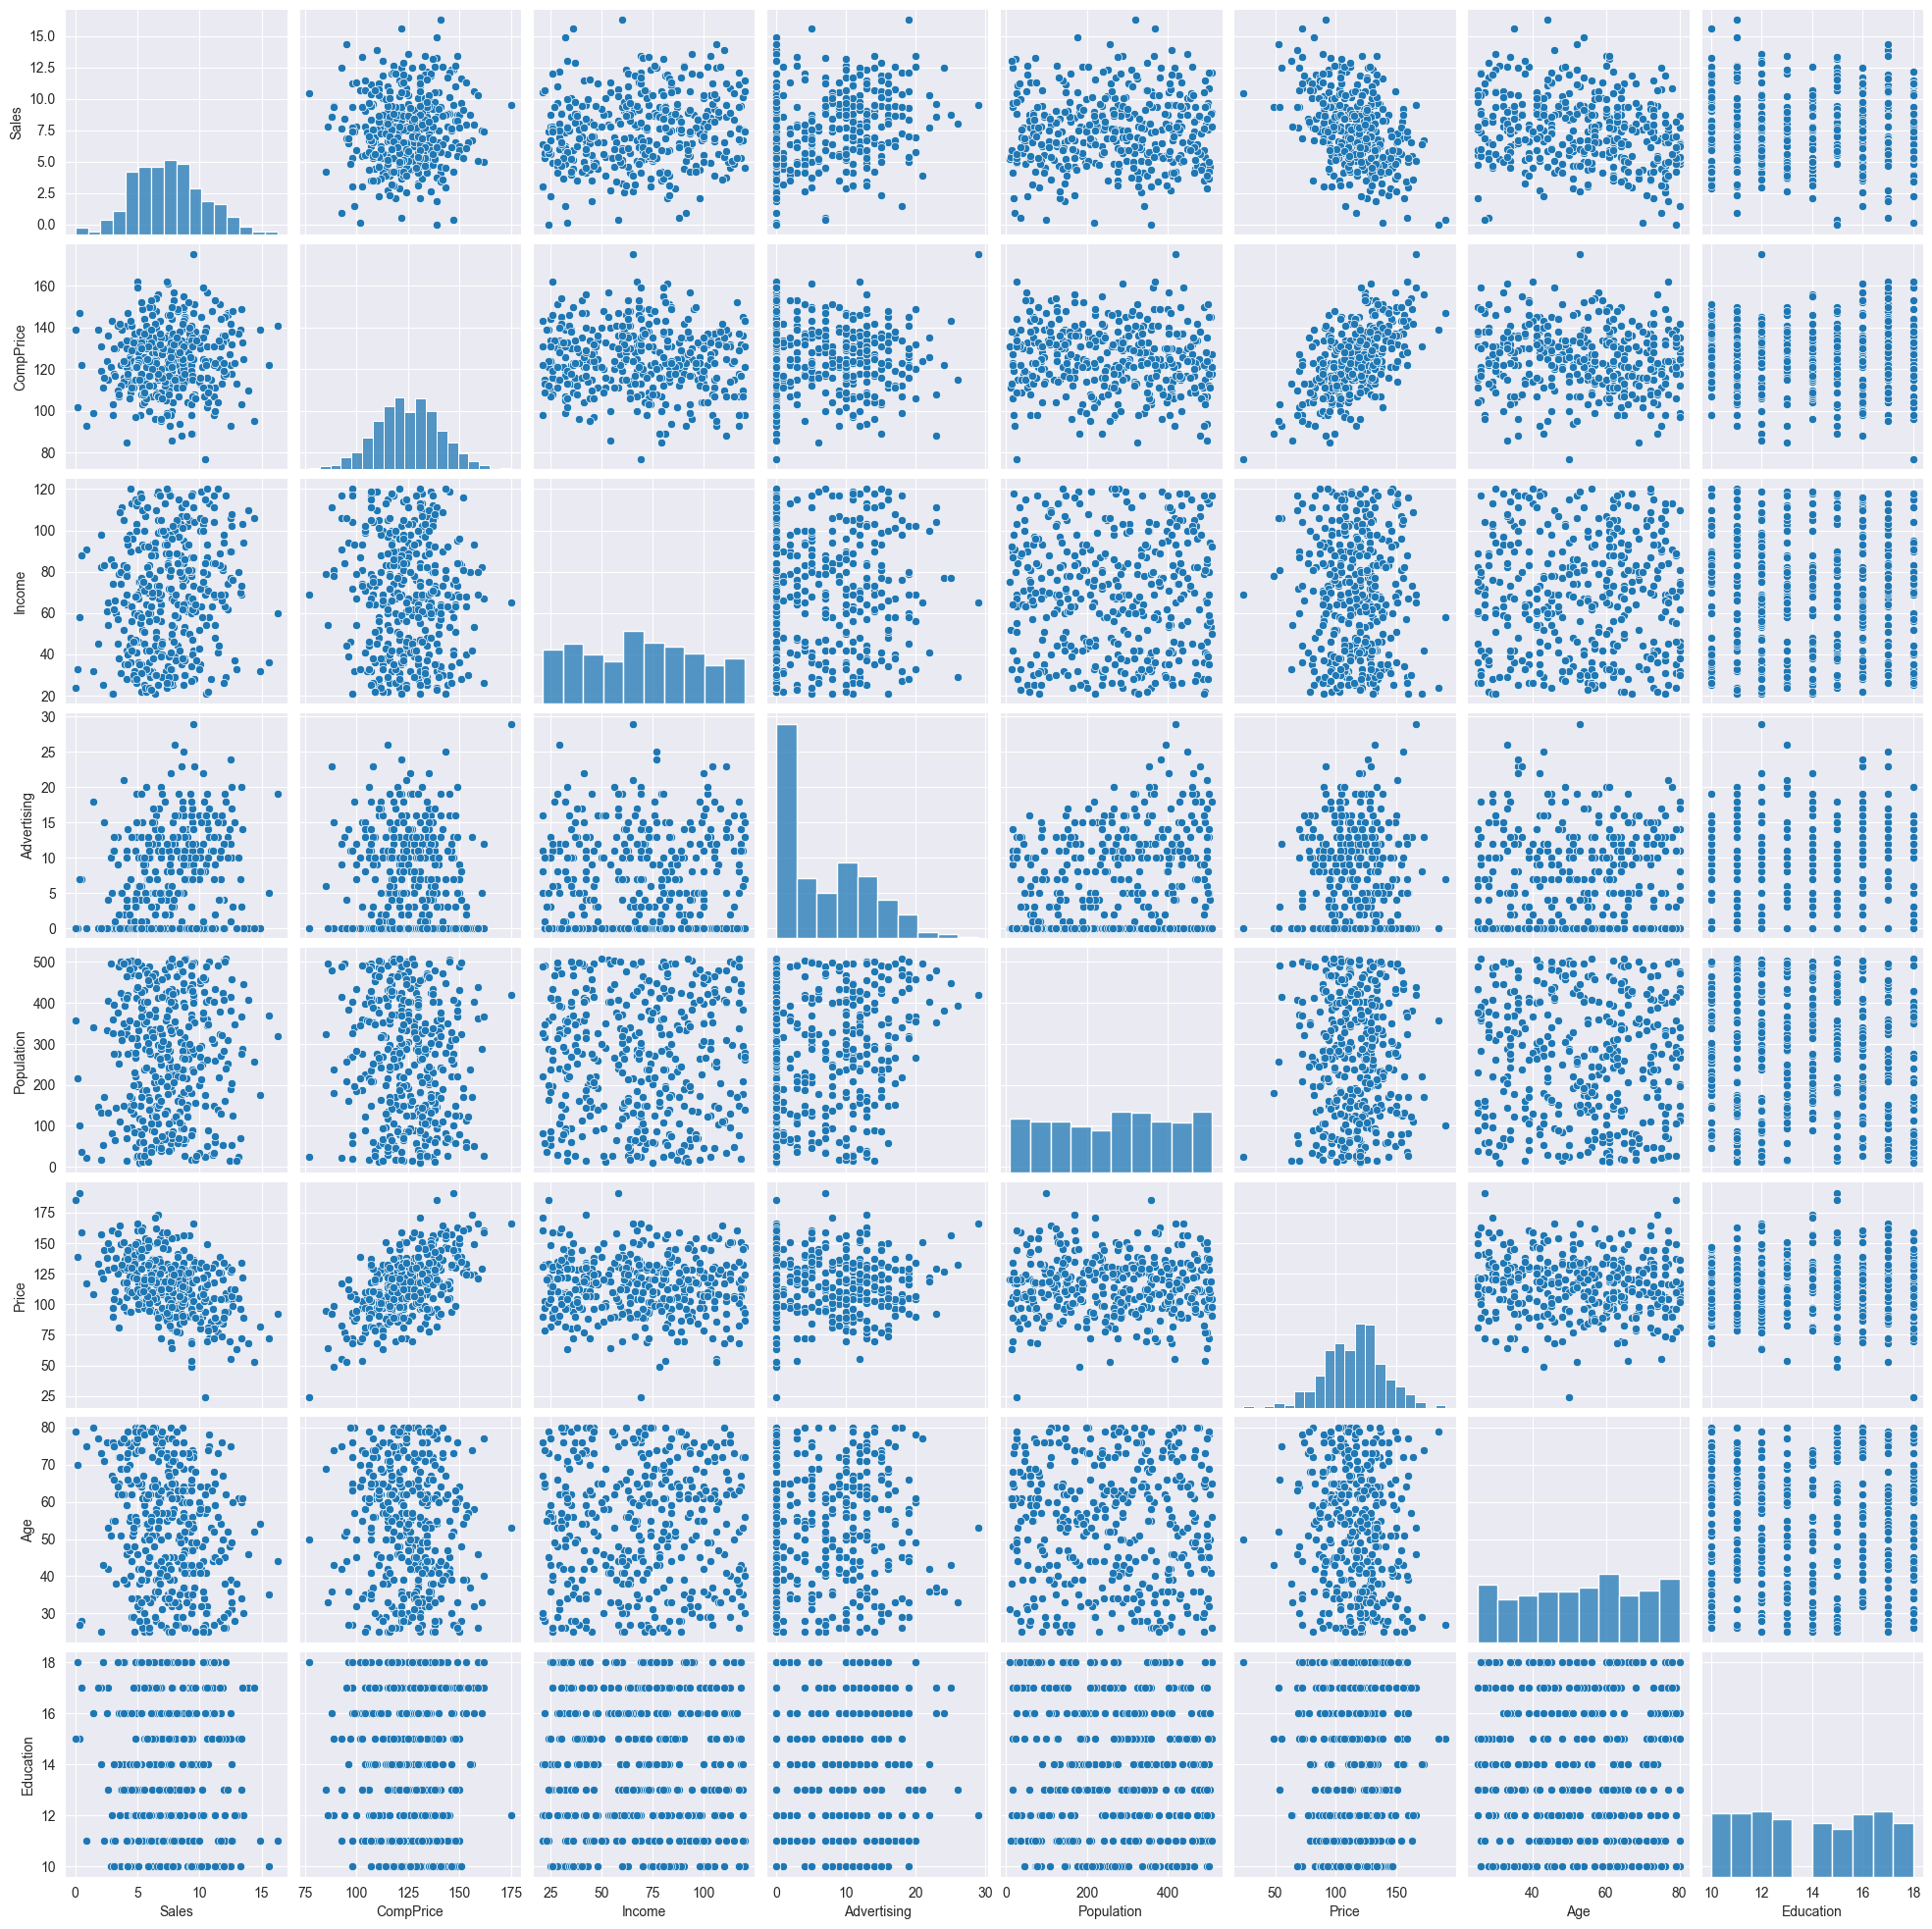

In [10]:
sns.pairplot(car_seats)  # hue="ShelveLoc"

What can we derive from the above diagram?

In [11]:
correlation = car_seats.corr(numeric_only=True)
correlation
# sns.heatmap(correlation, annot=True)

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
Sales,1.000000,0.064079,0.151951,0.269507,0.050471,-0.444951,-0.231815,-0.051955
CompPrice,0.064079,1.000000,-0.080653,-0.024199,-0.094707,0.584848,-0.100239,0.025197
Income,0.151951,-0.080653,1.000000,0.058995,-0.007877,-0.056698,-0.004670,-0.056855
Advertising,0.269507,-0.024199,0.058995,1.000000,0.265652,0.044537,-0.004557,-0.033594
Population,0.050471,-0.094707,-0.007877,0.265652,1.000000,-0.012144,-0.042663,-0.106378
Price,-0.444951,0.584848,-0.056698,0.044537,-0.012144,1.000000,-0.102177,0.011747
Age,-0.231815,-0.100239,-0.004670,-0.004557,-0.042663,-0.102177,1.000000,0.006488
Education,-0.051955,0.025197,-0.056855,-0.033594,-0.106378,0.011747,0.006488,1.000000


Heatmaps are a quick way to spot correlations between variables.

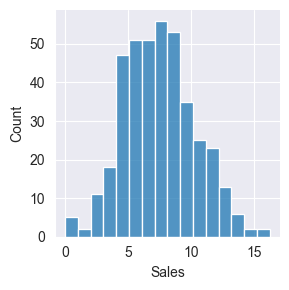

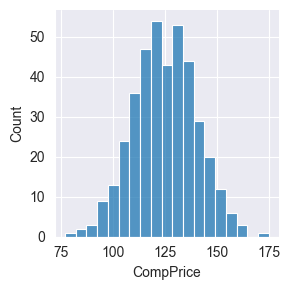

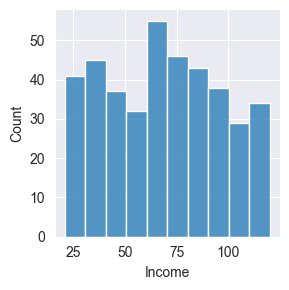

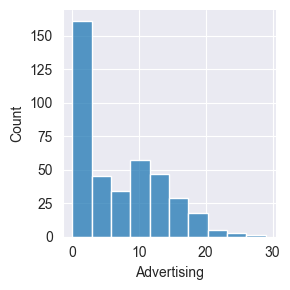

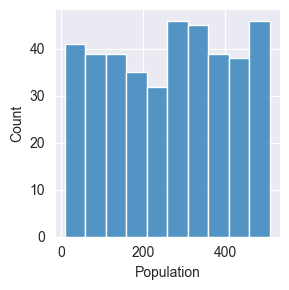

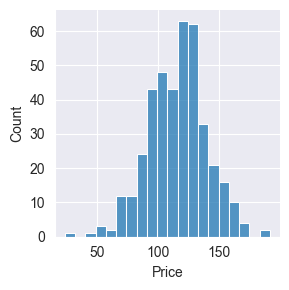

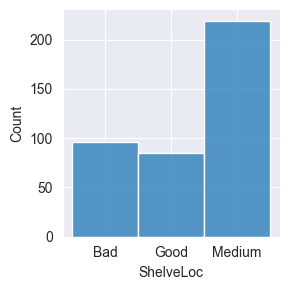

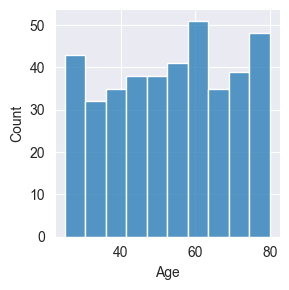

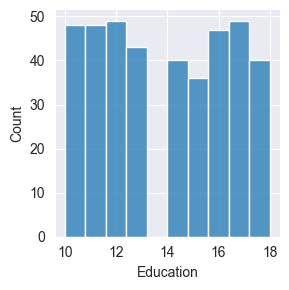

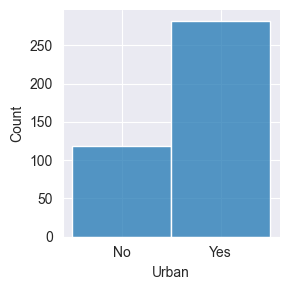

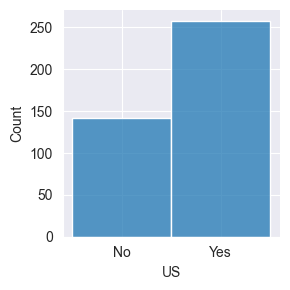

In [12]:
for column_name in car_seats.columns:
    sns.displot(car_seats[column_name], height=3)

<Axes: >

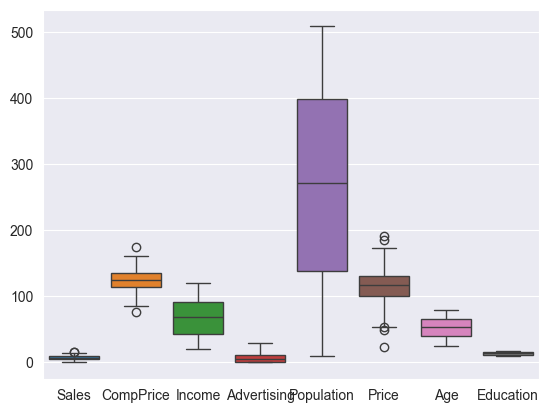

In [13]:
sns.boxplot(car_seats)

## 3. Preparation

Can a (linear) regression algorithm work with categorical features?

In [14]:
enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(car_seats[["ShelveLoc"]])
shelve_loc_ohe = enc.transform(car_seats[["ShelveLoc"]])
shelve_loc_ohe.toarray()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [15]:
list(enc.categories_[0])

['Bad', 'Good', 'Medium']

In [16]:
column_names = ["ShelveLoc" + category for category in list(enc.categories_[0])]
shelve_loc = pd.DataFrame(shelve_loc_ohe.toarray(), columns=column_names)
pd.concat([car_seats, shelve_loc], axis=1)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,ShelveLocBad,ShelveLocGood,ShelveLocMedium
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1.0,0.0,0.0
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,0.0,1.0,0.0
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,0.0,0.0,1.0
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0.0,0.0,1.0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes,0.0,1.0,0.0
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes,0.0,0.0,1.0
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes,0.0,0.0,1.0
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes,1.0,0.0,0.0


What's the difference between nominal and ordinal categorical features?

In [17]:
# Setting binary columns to 1/0 or True/False has the same effect when applying to most regressors. Boolean columns
# require less memory.
car_seats["UrbanEnc"] = car_seats["Urban"].transform(lambda boolean: boolean == "Yes")

In [18]:
car_seats["USEnc"] = car_seats["US"].transform(lambda boolean: boolean == "Yes")

In [19]:
car_seats["ShelveLocEnc"] = car_seats["ShelveLoc"].transform(
    lambda loc: 1 if loc == "Bad" else 2 if loc == "Medium" else 3
)

Is this a safe way to convert categorical values into numerical values? What if we have many different values?

In [21]:
shelve_loc_dict = {"Bad": 1, "Medium": 2, "Good": 3}
car_seats["ShelveLocEnc"] = car_seats["ShelveLoc"].map(shelve_loc_dict)

In [22]:
car_seats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,UrbanEnc,USEnc,ShelveLocEnc
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,True,True,1
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,True,True,3
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,True,True,2
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,True,True,2
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes,True,True,3
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes,False,True,2
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes,True,True,2
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes,True,True,1


What could we do more before training or linear regression model?

## 4. Linear Regression

Linear regression is a statistical method that models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data.

### The Linear Equation

The basic form of a linear regression model is:

y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε

Where:
- y is the dependent variable (what we're trying to predict)
- x₁, x₂, ..., xₙ are the independent variables (our features)
- β₀ is the y-intercept (value when all features are 0)
- β₁, β₂, ..., βₙ are the coefficients that determine the contribution of each feature
- ε represents the error term (the difference between predicted and actual values)

### How Linear Regression Works:

1. **Objective**: Find values for the coefficients (β₀, β₁, β₂, ...) that minimize the prediction error.

2. **Method**: Usually employs the "Ordinary Least Squares" approach, which minimizes the sum of squared differences between observed and predicted values.

3. **Interpretation**: 
    - Each coefficient represents the change in the output for a one-unit change in the corresponding feature, holding all other features constant.
    - The sign of the coefficient (+ or -) indicates the direction of the relationship.
    - The magnitude of the coefficient indicates the strength of the relationship.

4. **Assumptions**:
    - Linear relationship between variables
    - Independence of observations
    - Homoscedasticity (constant variance of errors)
    - Normal distribution of errors

In our car seat sales example, the model will determine how factors like price, advertising, and shelf location affect sales by finding the optimal coefficients for each feature.

In [23]:
X = car_seats[["Income", "Advertising", "Price", "Age", "CompPrice", "ShelveLocEnc"]]
y = car_seats["Sales"]

reg = LinearRegression().fit(X, y)

In [24]:
data = {"Income": [10], "Advertising": [20], "Price": [100], "Age": [20], "CompPrice": [100], "ShelveLocEnc": [3]}
X_new = pd.DataFrame(data)
reg.predict(X_new)

array([11.33380106])

In [25]:
coefficients = reg.coef_
coefficients

array([ 0.01617884,  0.11639834, -0.09516875, -0.04692869,  0.09230756,
        2.40314589])

In [26]:
intercept = reg.intercept_
intercept

np.float64(2.859300648723199)

Try to obtain the same result as the model by using the values in ``data``, ``coefficients`` and ``intercept`` variables.

In [31]:
def predict_sales(data: dict[str, list[float]], coefficients: np.ndarray[float], intercept: np.float64) -> float:
    """Generate a prediction of sales based on the coefficients and intercept of a linear regression model.

    ``Data`` contains the input features

    :param data: A dictionary containing the input features for the prediction, e.g.,
        {"Income": [10], "Advertising": [20], "Price": [100], "Age": [20], "CompPrice": [100], "ShelveLocEnc": [3]}
    :param coefficients: The coefficients of the linear regression model.
    :param intercept: The intercept of the linear regression model.
    """
    # Add your code here

In [33]:
raw_data = np.array([value[0] for value in data.values()], dtype=np.float64)

predicted_sales = predict_sales(data, coefficients, intercept)
model_sales = reg.predict(X_new)[0]

print(f"Predicted sales: {predicted_sales}")
print(f"Model sales: {model_sales}")

if round(predicted_sales, 3) == round(model_sales, 3):
    print("The predicted sales match the model's prediction.")

else:
    print("The predicted sales do not match the model's prediction.")

Predicted sales: 11.333801058712563
Model sales: 11.333801058712565
The predicted sales match the model's prediction.


## 5. Logistic Regression

Logistic regression is a statistical method used for binary classification problems - predicting outcomes with two possible values (e.g., yes/no, 0/1, true/false).

Unlike linear regression which predicts continuous values, logistic regression predicts the probability that an instance belongs to a particular class.

### The Logistic Function

Logistic regression uses the sigmoid function (also called the logistic function) to transform its output to a probability between 0 and 1:

$P(y=1|x) = \frac{1}{1 + e^{-z}}$

Where $z = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$ (the linear combination of features)

![Sigmoid function](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

### How Logistic Regression Works:

1. **Model Formula**: $\log(\frac{p}{1-p}) = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$
    - $p$ is the probability of the positive class
    - $\frac{p}{1-p}$ is the odds ratio
    - $\log(\frac{p}{1-p})$ is the log odds or "logit"

2. **Decision Boundary**: When probability > 0.5, we predict class 1; otherwise, we predict class 0

3. **Training**: Uses maximum likelihood estimation to find the best parameters

### Key Differences from Linear Regression:

- Predicts probabilities instead of continuous values
- Output is bounded between 0 and 1
- Uses log loss (cross-entropy) instead of mean squared error
- Decision boundary is non-linear in input space but linear in feature space

In [35]:
X = car_seats[["Income", "Advertising", "Price", "Age", "CompPrice", "ShelveLocEnc", "Sales"]]
y = car_seats["USEnc"]

In this example, we will use logistic regression to predict whether is sold in the US or not based on other features. The model will output a probability, and we will classify it as "sold in the US" if the probability is greater than 0.5.

In [36]:
log_reg = LogisticRegression().fit(X, y)

In [37]:
data = {
    "Income": [10],
    "Advertising": [20],
    "Price": [100],
    "Age": [20],
    "CompPrice": [100],
    "ShelveLocEnc": [3],
    "Sales": [10],
}
X_new = pd.DataFrame(data)
log_reg.predict(X_new)

array([1.])